In [2]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [3]:
test_o, test_d, test_target_px_values = get_rays('dataset', mode='test')

In [4]:
device = 'cuda'
tn = 8.
tf = 12.

In [5]:
model = torch.load('model_nerf').to(device)

In [78]:
def mse2psnr(mse):
    mse = mse.cpu()
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device='cuda')
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3)
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
        image = image.cpu().numpy()
        return image, mse.item(), psnr.item()
    else:
        image = image.cpu().numpy()
        return image

In [94]:
for i in range(10):
    img, mse, psnr = test(model,
                        torch.from_numpy(test_o[i]).to(device).float(),
                        torch.from_numpy(test_d[i]).to(device).float(),
                        tn, tf,
                        nb_bins=100,
                        chunk_size=10, 
                        target=torch.from_numpy(test_target_px_values[i].reshape(400, 400, 3)).to(device).float())
    # save image
    img = np.squeeze(img)
    img = (img * 255).astype(np.uint8)
    imageio.imwrite(f'{i}_img.png', img)


print(psnr)

31.601516723632812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


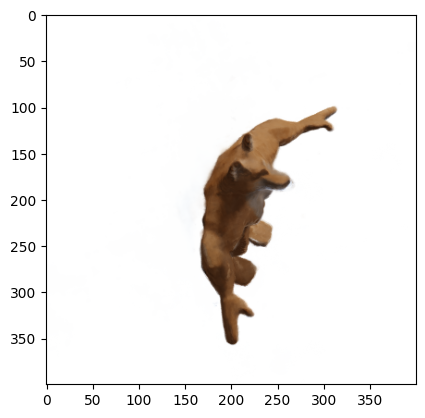

In [85]:
plt.imshow(img)